## Lesson 21 - Analyze Netflix data using graphs





### Table of Contents
- [About Netflix](#netflix)
- [Load the Netflix data](#load_data)
- [Graph cardinalities](#graph_cardinalities)
- [TOP 5 ACTOR - Greatest Number of films played](#top5)
- [Count by Category](#count_by_category)
- [Shortest between 2 persons](#shortest_between_2_persons)
- [Recommendation](#recommendation)
- [Evolution over year - Number of movies by countries](#evolution_over_year)








<a id="netflix"></a>
## About Netflix
How people ratings 王牌辯護人?

That's a question that has run through my head repeatedly over the years. The beloved sitcom has been my top choice for a long time.

It used to be a question I couldn't answer, because the data Netflix won't allowed users to download (but user can still download their activity in csv).

Now, though, Netflix Kaggle compitition, allows you to download a veritable treasure-trove of data about each episode. The object of this session is:

- to test the interaction with Neo4j
- and use the graph algorithms to find similarities and recommendations
<img src="images/analyse_netflix_data_using_graph.png">

In [1]:
import time
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import py2neo

from matplotlib.font_manager import FontProperties
from py2neo import Graph

# Windows
myfont = FontProperties(fname=r'C:\Windows\Fonts\kaiu.ttf',size=14)

# Mac OS
#myfont = FontProperties(fname="/Users/mac/Library/Fonts/NotoSansHant-Medium.otf", size=14)

sns.set(font=myfont.get_name())

%matplotlib inline
plt.style.use('seaborn-whitegrid')

print(py2neo.__version__)

5.0b1


<a id="load_data"></a>
## Load the Netflix data

Download the [data](https://www.kaggle.com/shivamb/netflix-shows) to your computer.

In [2]:
df = pd.read_csv('./data/netflix/netflix_titles.csv')
df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020.0,8.0,14.0
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016.0,12.0,23.0
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018.0,12.0,20.0
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017.0,11.0,16.0
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020.0,1.0,1.0


### Load the data from the dataframe to neo4j graph DB

Notice: execution time can be long, about 6 minutes for requests as `create movies` or `create persons`

So execute it, only once put LOAD_DATA = false, to not load data again

I have tried the idea to not send a lot of queries through the net :

- the first request load all the data as properties of the nodes Movies.
- the other requests build the other nodes with these properties
- at the end, the final request delete the unused properties

### enable localhost access, or your public ip, domain name etc.
<img src="images/neo4j_enable_localhost.png">

### Install APOC & Graph Data Science Library
<img src="images/neo4j_install_apoc_gds.png">

In [3]:
# http://127.0.0.1:7474/browser/
graph = Graph('http://127.0.0.1:7474', username='neo4j', password='42840667')
transaction = graph.begin()

In [4]:
LOAD_DATA = True

def run_request(request, LOAD_DATA=False):
    if (LOAD_DATA):
        start_time = time.time()
        print(graph.run(request)) 
        exec_time = time.time() - start_time
        print(f'-- {exec_time} seconds --')

In [5]:
# DELETE ALL NODES AND RELATIONSHIPS
request_delete ="""
MATCH (n) DETACH DELETE n;
"""
run_request(request_delete, LOAD_DATA)


-- 0.6510665416717529 seconds --


In [6]:
request ="""
CREATE (m:Movie {id: $show_id, title:$title})
SET 
m.director = $director,
m.country = $country,
m.date_str = $date_added, 
m.release_year = $release_year,
m.rating = $rating,
m.duration = $duration,
m.listed_in = $listed_in,
m.description = $description,
m.cast = $cast,
m.year = $year,
m.month = $month,
m.day = $day,
m.type = $type_movie
"""
start_time = time.time()
count=df.shape[0]
if (LOAD_DATA):
    for index, row in df.iterrows():
        graph.run(request,
                  show_id=row['show_id'],
                  title=row['title'],
                  director=None if pd.isnull(row['director']) else row['director'],
                  country=None if pd.isnull(row['country']) else row['country'],
                  date_added= None if pd.isnull(row['date_added']) else row['date_added'].strftime('%Y-%m-%d'),
                  release_year=None if pd.isnull(row['release_year']) else row['release_year'],
                  rating=None if pd.isnull(row['rating']) else row['rating'],          
                  duration=None if pd.isnull(row['duration']) else row['duration'],
                  listed_in=None if pd.isnull(row['listed_in']) else row['listed_in'],
                  description=None if pd.isnull(row['description']) else row['description'],
                  cast= None if pd.isnull(row['cast']) else row['cast'],
                  year=None if pd.isnull(row['year']) else row['year'],
                  month=None if pd.isnull(row['month']) else row['month'],
                  day=None if pd.isnull(row['day']) else row['day'],
                  type_movie=None if pd.isnull(row['type']) else row['type']
                  )
        if (index%500==0):
            exec_time = time.time() - start_time
            print(f'{index}/{df.shape[0]} done ... -- {exec_time} seconds --')

    exec_time = time.time() - start_time
    print(f' ... End ... -- {exec_time} seconds --')

0/7787 done ... -- 0.3787803649902344 seconds --
500/7787 done ... -- 5.125551223754883 seconds --
1000/7787 done ... -- 8.551947116851807 seconds --
1500/7787 done ... -- 11.719141483306885 seconds --
2000/7787 done ... -- 14.788352727890015 seconds --
2500/7787 done ... -- 17.826533555984497 seconds --
3000/7787 done ... -- 20.76275110244751 seconds --
3500/7787 done ... -- 23.65630030632019 seconds --
4000/7787 done ... -- 26.574928283691406 seconds --
4500/7787 done ... -- 29.508315563201904 seconds --
5000/7787 done ... -- 32.419533252716064 seconds --
5500/7787 done ... -- 35.19644594192505 seconds --
6000/7787 done ... -- 37.992531538009644 seconds --
6500/7787 done ... -- 40.76964783668518 seconds --
7000/7787 done ... -- 43.575711250305176 seconds --
7500/7787 done ... -- 46.326470136642456 seconds --
 ... End ... -- 47.87985682487488 seconds --


In [7]:
# CREATE PERSONS
request ="""
MATCH (m:Movie)
WHERE m.cast IS NOT NULL
WITH m
UNWIND split(m.cast, ',') AS actor
MERGE (p:Person {name: trim(actor)})
MERGE (p)-[r:ACTED_IN]->(m);
"""    
run_request(request, LOAD_DATA)


-- 504.6795160770416 seconds --


In [8]:
# CREATE CATEGORIES    
request ="""    
MATCH (m:Movie)
WHERE m.listed_in IS NOT NULL
WITH m
UNWIND split(m.listed_in, ',') AS category
MERGE (c:Category {name: trim(category)})
MERGE (m)-[r:IN_CATEGORY]->(c);
"""    
run_request(request, LOAD_DATA)


-- 0.7651011943817139 seconds --


In [9]:
# CREATE TYPE
request =""" 
MATCH (m:Movie)
WHERE m.type IS NOT NULL
WITH m
MERGE (t:Type {type: m.type})
MERGE (m)-[r:TYPED_AS]->(t);
"""
run_request(request, LOAD_DATA)


-- 0.327791690826416 seconds --


In [10]:
# CREATE DIRECTOR
request =""" 
MATCH (m:Movie)
WHERE m.director IS NOT NULL
WITH m
MERGE (d:Person {name: m.director})
MERGE (d)-[r:DIRECTED]->(m);
"""
run_request(request, LOAD_DATA)


-- 107.98202252388 seconds --


In [11]:
# CREATE COUNTRIES
request =""" 
MATCH (m:Movie)
WHERE m.country IS NOT NULL
MERGE (c:Country {name: trim(m.country)})
MERGE (m)-[:WHERE]->(c);
"""
run_request(request, LOAD_DATA)


-- 1.1758637428283691 seconds --


In [12]:
# DELETE UNUSED PROPERTY
request="""
MATCH(m:Movie)
SET m.country = null, m.category = null,m.type = null , m.director = null , m.cast =null
"""
run_request(request, LOAD_DATA)


-- 0.36415982246398926 seconds --


In [13]:
# BUILD THE WORK_WITH RELATIONSHIP
request = """
MATCH (p:Person)-[rel:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(p2:Person)
MERGE (p)-[r:WORK_WITH]-(p2);
"""
run_request(request, LOAD_DATA)


-- 6.580874443054199 seconds --


In [14]:
# Create Time Tree Index
request="""
CREATE INDEX ON :Year(value);
"""
run_request(request, LOAD_DATA)


-- 0.12046408653259277 seconds --


In [15]:
# Create Years
request="""
WITH range(2012, 2019) AS years, range(1,12) AS months
FOREACH(year IN years |
  CREATE (y:Year {value: year}));
"""
run_request(request, LOAD_DATA)


-- 0.10972189903259277 seconds --


In [16]:
# Connect Years Sequentially
request="""
MATCH (year:Year)
WITH year
ORDER BY year.value
WITH collect(year) AS years
FOREACH(i in RANGE(0, size(years)-2) |
    FOREACH(year1 in [years[i]] |
        FOREACH(year2 in [years[i+1]] |
            MERGE (year1)-[:NEXT]->(year2))));
"""
run_request(request, LOAD_DATA)


-- 0.13090848922729492 seconds --


In [17]:
# Test Cypher query
request="""
MATCH (m:Movie)
WITH m, m.year AS y
MATCH (year:Year {value: y})
MERGE (m)-[:CREATED_ON]->(year)
RETURN m,year;
"""
run_request(request, LOAD_DATA)

 m                                                                                                                                                                                                                                                                                                                                                                                                    | year                        
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------
 (_7788:Movie {date_str: '2016-12-23', day: 23.0, description: 'After a devastating earthquake hits Mexico City, trapped survivors from all walks of life wait

<a id="graph_cardinalities"></a>
## Graph cardinalities

In [18]:
# Nodes Cardinalities
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
3,Type,2
5,Year,8
2,Category,42
4,Country,681
0,Movie,7787
1,Person,36565


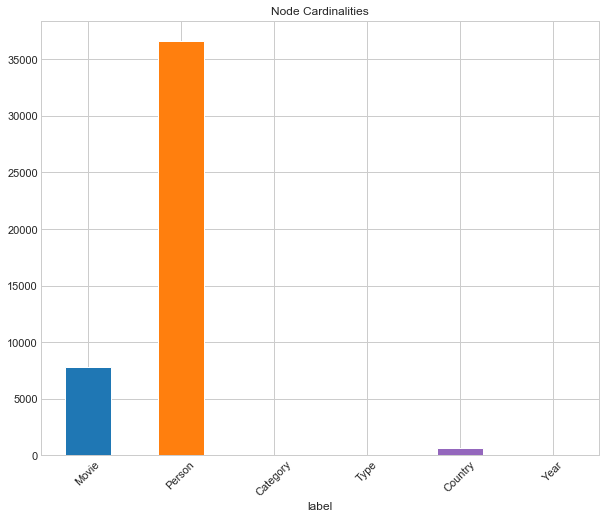

In [19]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities",figsize=(10,8), rot=45, color=colors)

In [20]:
# Relations Ship Cardinalities
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
6,NEXT,7
3,DIRECTED,5398
7,CREATED_ON,5633
4,WHERE,7280
2,TYPED_AS,7787
1,IN_CATEGORY,17071
0,ACTED_IN,55953
5,WORK_WITH,252053


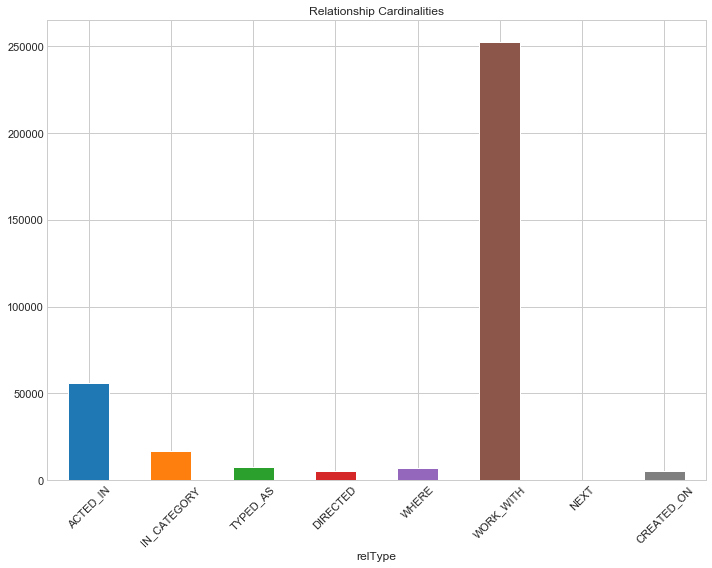

In [21]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities",figsize=(10,8), color=colors)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<a id="top5"></a>
## TOP 5 ACTOR - Greatest Number of films played

In [22]:
request_top_5_actor="""
MATCH (p:Person)-[rel:ACTED_IN]->(m:Movie)
WITH p,collect(m.title) as movies,count(*) as total
RETURN p.name, movies,total
ORDER BY total DESC
LIMIT 5
"""
graph.run(request_top_5_actor).to_data_frame().head()

,p.name,movies,total
0,Anupam Kher,"[A Family Man, A Wednesday, Aiyaary, C Kkompan...",42
1,Shah Rukh Khan,"[Asoka, Billu, Chaahat, Chalte Chalte, Chamatk...",35
2,Om Puri,"[Action Replayy, Bhaji In Problem, Billu, Boll...",30
3,Naseeruddin Shah,"[3 Deewarein, 7 Khoon Maaf, A Wednesday, Aiyaa...",30
4,Takahiro Sakurai,"[​SAINT SEIYA: Knights of the Zodiac, 7SEEDS, ...",29


<a id="count_by_category"></a>
## Count by Category

The grand total does not equal the number of movies, because a movie can be in several categories

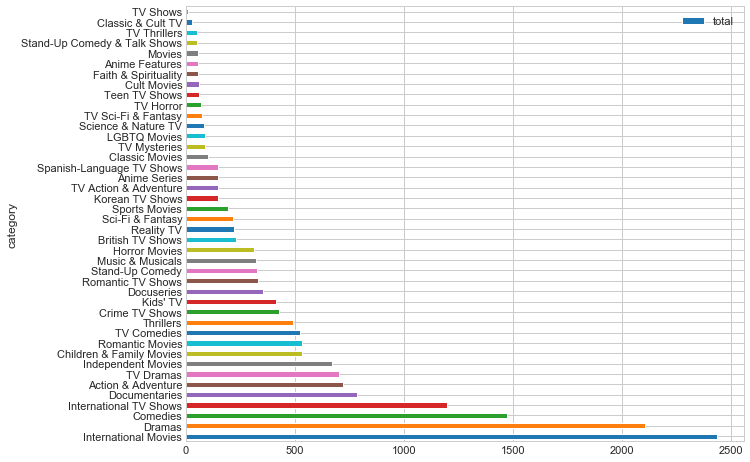

In [23]:
request="""
MATCH (c:Category)<-[rel:IN_CATEGORY]-(m:Movie)
WITH c.name as category,count(*) as total
RETURN  category,total
ORDER BY total DESC
"""
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
result = graph.run(request).to_data_frame()
result.plot.barh(x='category', y='total', figsize=(10,8), color=colors)
plt.show()

<a id="shortest_between_2_persons"></a>
## Shortest between 2 persons

If I want to meet someone, who should I ask to be present?

In [24]:
'''
MATCH (cs:Person { name: 'Tom Cruise' }),(ms:Person { name: 'Tom Hanks' }), p = shortestPath((cs)-[:ACTED_IN|DIRECTED*]-(ms))
WHERE length(p)> 1 
RETURN p
'''
def who_be_present(I_AM, I_WANT_TO_MEET):
    print(f"I'm {I_AM}")
    print(f"I want to meet {I_WANT_TO_MEET}")
    request="""
    MATCH (cs:Person { name: $pfrom }),(ms:Person { name: $pto }), p = shortestPath((cs)-[:ACTED_IN|DIRECTED*]-(ms))
    WHERE length(p)> 1 
    RETURN p
    """
    cursor = graph.run(request, pfrom=I_AM, pto=I_WANT_TO_MEET)
    while cursor.forward():
        print(cursor['p'])
    print('\n')

I_AM = 'Tom Cruise'
I_WANT_TO_MEET = 'Tom Hanks'
who_be_present(I_AM, I_WANT_TO_MEET)

I'm Tom Cruise
I want to meet Tom Hanks
(Tom Cruise)-[:ACTED_IN {}]->(_11647)<-[:ACTED_IN {}]-(Alfred Molina)-[:ACTED_IN {}]->(_14049)<-[:ACTED_IN {}]-(Tom Hanks)




In [25]:
I_AM = 'Nicolas Cage'
I_WANT_TO_MEET='Harrison Ford'
who_be_present(I_AM, I_WANT_TO_MEET)

I'm Nicolas Cage
I want to meet Harrison Ford
(Nicolas Cage)-[:ACTED_IN {}]->(_15164)<-[:ACTED_IN {}]-(James Remar)-[:ACTED_IN {}]->(_15345)<-[:ACTED_IN {}]-(Harrison Ford)




<img src="images/netflix_actor_shortest_path.png">

## Similarity between categories

The similarity between two categories is evaluated with the overlap of the movies sets that each category contains :

Overlap similarity measures overlap between two sets. It is defined as the size of the intersection of two sets, divided by the size of the smaller of the two sets. https://neo4j.com/docs/graph-algorithms/current/labs-algorithms/overlap/

$O(A,B)=\frac{ |A \cap B|}{min(|A|,|B|)}$

<img src="images/overlap_similarity_algorithm.png">

Checking APOC and Graph Data Science Library (GDS)

<img src="images/apoc_gds_library_plugin.png">


```
CALL dbms.procedures
```

<img src="images/call_dbms_procedures.png">

```
CALL gds.list()
```

<img src="images/gds_list.png">

ref. https://neo4j.com/docs/graph-data-science/current/alpha-algorithms/overlap/

In [26]:
# SIMILARITY BETWEEN CATEGORY
query = """
MATCH (m:Movie)-[:IN_CATEGORY]->(cat:Category)
WITH {item:id(cat), categories: collect(id(m))} as userData
WITH collect(userData) as data
CALL gds.alpha.similarity.overlap.stream({data: data})
YIELD item1, item2, count1, count2, intersection, similarity
RETURN gds.util.asNode(item1).name AS from, gds.util.asNode(item2).name AS to,
       count1, count2, intersection, similarity
ORDER BY from,to DESC
"""

start_time = time.time()
cat_result = graph.run(query).to_data_frame()
exec_time = time.time() - start_time
print(f'-- {exec_time} seconds --')
cat_result.head()

-- 5.134585857391357 seconds --


,from,to,count1,count2,intersection,similarity
0,Action & Adventure,International Movies,721,2437,353,0.489598
1,Action & Adventure,Dramas,721,2106,198,0.274619
2,Action & Adventure,Comedies,721,1471,161,0.223301
3,Anime Features,International Movies,57,2437,34,0.596491
4,Anime Features,Children & Family Movies,57,532,12,0.210526


In [27]:
# Create the set of categories
set1 = set(cat_result['to'].unique())
set2 = set(cat_result['from'].unique())
categories = np.asarray(list(set1 | set2))
categories.sort()
nbr_cat = categories.shape[0]

# Create a dictionary key=categorie , value = index 
cat_index = np.arange(nbr_cat)
dictionary = dict(zip(categories, cat_index))

# Create a matrix of distance ( distance = 1 - similarity )
matrix = 1 - np.eye(nbr_cat)
for index, row in cat_result.iterrows():
    matrix[dictionary[row['from']],dictionary[row['to']]]=1-row['similarity']
    matrix[dictionary[row['to']],dictionary[row['from']]]=1-row['similarity']

# Convert the matrix to a 1d condensed matrix
cmatrix = []
for i in range(0,nbr_cat-1):
    for j in range(i+1,nbr_cat):
        cmatrix.append(matrix[i,j])

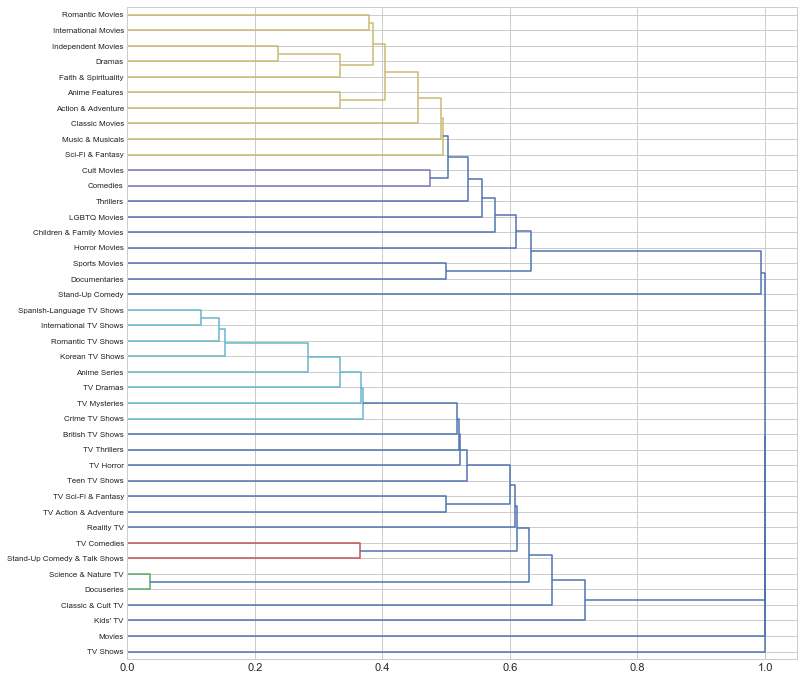

In [28]:
# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage
linkage = linkage(np.asarray(cmatrix))

fig, axes = plt.subplots(1, 1, figsize=(12, 12))
dendro  = dendrogram(linkage, labels=categories, orientation='right', ax=axes, color_threshold=0.5)
plt.show()

<a id="recommendation"></a>
## Recommendation

These algorithms help determine the closeness of a pair of nodes.

Adamic Adar is a measure used to compute the closeness of nodes based on their shared neighbors.

https://neo4j.com/docs/graph-data-science/current/alpha-algorithms/adamic-adar/

x and y are nodes (Movies)

if N(x) is the set of nodes adjacent to x
if N(y) is the set of nodes adjacent to y

<img src="images/adamic-adar.png">

In [29]:
# LINK PREDICTION BETWEEN MOVIES
request_link_prediction_movie="""
MATCH (a:Movie {title:$ptitle} )-[*2]-(b:Movie)
WHERE a <> b AND a.title < b.title
WITH DISTINCT a,b
RETURN a.title as title, b.title as recommendation, gds.alpha.linkprediction.adamicAdar(a, b) AS score
ORDER BY score DESC
LIMIT 10
"""
print(graph.run(request_link_prediction_movie,ptitle='Stranger Things').to_data_frame())
print(graph.run(request_link_prediction_movie,ptitle="Ocean's Thirteen").to_data_frame())

             title              recommendation     score
0  Stranger Things                      The OA  0.839301
1  Stranger Things            ThirTEEN Terrors  0.717114
2  Stranger Things                  Typewriter  0.717114
3  Stranger Things  The Haunting of Hill House  0.714278
4  Stranger Things   The Haunting of Bly Manor  0.714278
5  Stranger Things               The Originals  0.714278
6  Stranger Things         The Vampire Diaries  0.709009
7  Stranger Things              The Messengers  0.709009
8  Stranger Things                 Warrior Nun  0.709009
9  Stranger Things                    Z Nation  0.622339
              title                             recommendation     score
0  Ocean's Thirteen                             Ocean's Twelve  3.251960
1  Ocean's Thirteen                             The Informant!  1.161873
2  Ocean's Thirteen                             The Laundromat  1.069380
3  Ocean's Thirteen  True Memoirs of an International Assassin  0.771621
4  Ocean

<a id="evolution_over_year"></a>
## Evolution over year - Number of movies by countries

In [30]:
request = """
MATCH (y:Year {value: 2012})-[:NEXT*0..10]->(y2:Year)<-[:CREATED_ON]-(f:Movie)-[r:WHERE]->(c:Country)
RETURN y2.value as year,c.name as country,count(r) as count
ORDER BY year DESC, count DESC
"""
result = graph.run(request).to_data_frame()
filter_result = result['country'][:10]

In [31]:
temp = result.loc[result['country'].isin(filter_result)]
temp = temp.set_index(['year', 'country'])
temp = temp.unstack(level=-1)
temp.fillna(0,inplace=True)
temp.head()

count                                                         \
country Canada Egypt France India Japan Philippines South Korea Spain   
year                                                                    
2012       0.0   0.0    0.0   0.0   0.0         0.0         0.0   0.0   
2013       1.0   0.0    0.0   0.0   0.0         0.0         0.0   0.0   
2014       1.0   0.0    0.0   0.0   0.0         0.0         0.0   0.0   
2015       4.0   0.0    2.0   0.0   1.0         0.0         0.0   0.0   
2016      13.0   0.0    8.0  11.0  17.0         0.0         9.0  11.0   

                                      
country United Kingdom United States  
year                                  
2012               0.0           2.0  
2013               0.0           8.0  
2014               0.0          16.0  
2015               3.0          52.0  
2016              37.0         159.0

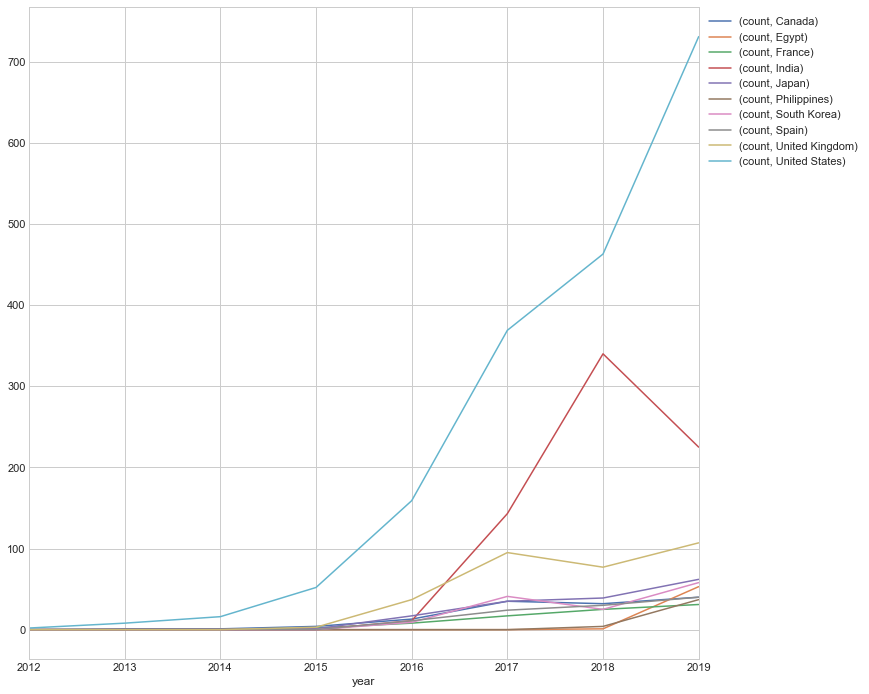

In [32]:
temp.plot(figsize=(12, 12)).legend(bbox_to_anchor=(1, 1))
plt.show()

## Summary

This was really insightful and useful! But it will take a while considering it is 'unwinding' the cast list for each movie.